## Features:
### DNA features:
- 3-mer frequencies
- GC-content
- sequence length
- start codon (is ATG?)

### Protein features:
- ESM3 embeddings
- protein length
- Secondary Structure related
    - Secondary Structure Content (e.g. alpha helicex, sheets, coils)
    - Solvent Accessibility
    - Secondary Structure Transitions

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, SamplingConfig, GenerationConfig
from esm.utils.constants.models import ESM3_OPEN_SMALL
import tqdm
import numpy as np
from Bio import SeqIO
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

## Import datasets and organize

In [2]:
def fasta_to_df(path):
    """Parses either a folder of FASTA files, or a single FASTA file into a pandas dataframe."""
    data = []

    # Determine if path is a file or folder
    if os.path.isfile(path):
        files = [path]
    elif os.path.isdir(path):
        files = [os.path.join(path, f) for f in os.listdir(path)]

    for file in files:
        for record in SeqIO.parse(file, "fasta"):
            desc = record.description
            alt = next(  ## For fasta with [protein_id] fields
                (
                    x.split("=")[1][:-1]
                    for x in desc.split()
                    if x.startswith("[locus_tag=")
                ),
                next(
                    (
                        "gene-" + x.split("=")[1][:-1]
                        for x in desc.split()
                        if x.startswith("[gene=")
                    ),
                    None,
                ),
            )
            ## This is either [locus_tag=_] or [gene=_]
            prot_id = next(  ## For fasta with [protein_id] fields
                (x.split("=")[1][:-1] for x in desc.split() if x.startswith("[gene=")),
                next(
                    (
                        "gene-" + x.split("=")[1][:-1]
                        for x in desc.split()
                        if x.startswith("[locus_tag=")
                    ),
                    None,
                ),
            )
            if prot_id:
                data.append((prot_id, alt, str(record.seq)))

    return pd.DataFrame(data, columns=["id", "alt", "sequence"])


def load_dataset(
    dataset_name, phage_accession, gene_classification, aa_fasta, na_fasta
):
    """
    For a dataset with input files above:
    Return a dataset with columns: gene, classification, aa_seq, na_seq and dataset_name, phage_accession
    """
    # Create dataframe for each file
    df_class = pd.read_csv(gene_classification)

    df_proteins = fasta_to_df(aa_fasta)
    df_proteins.rename(columns={"id": "gene", "sequence": "aa_seq"}, inplace=True)

    df_genes = fasta_to_df(na_fasta)
    df_genes.rename(columns={"id": "gene", "sequence": "na_seq"}, inplace=True)

    # Combine dataframes into one on "gene"-column
    df_combined = df_class.merge(df_proteins, on="gene", how="outer").merge(
        df_genes, on="gene", how="outer"
    )

    return df_combined

In [3]:
# Load and combine all datasets listed in accession_list.csv
master_list = pd.read_csv("data/datasets/accession_list.csv")

all_datasets = []

for _, row in master_list.iterrows():
    dataset_name = row["dataset"]
    phage_accession = row["NCBI GenBank accession"]

    gene_classification = f"data/datasets/{dataset_name}/gene_classification.csv"
    aa_fasta = f"data/proteins_aa/{phage_accession}.fasta"
    na_fasta = f"data/proteins_na/{phage_accession}.fasta"

    df = load_dataset(
        dataset_name, phage_accession, gene_classification, aa_fasta, na_fasta
    )
    all_datasets.append(df)

# Combine into one dataframe
df_all = pd.concat(all_datasets, ignore_index=True)
# Drop rows with na values
df_all = df_all.drop("alt_y", axis="columns")  # Artifact cause by alt names
print(df_all)
df_clean = df_all.dropna()

print(f"Dropped {len(df_all) - len(df_clean)} rows.")

# df_clean.to_csv("out.csv")
print(df_clean.shape)

                           gene classification                 alt_x  \
0     gene-PPLUZ19_PPLUZ19_gp20         middle  PPLUZ19_PPLUZ19_gp20   
1                         gp0.1         middle         PPLUZ19_gp0.1   
2                           gp1          early           PPLUZ19_gp1   
3                          gp10         middle          PPLUZ19_gp10   
4                          gp11         middle          PPLUZ19_gp11   
...                         ...            ...                   ...   
1211             gene-M172_gp50           late             M172_gp50   
1212             gene-M172_gp51           late             M172_gp51   
1213             gene-M172_gp52           late             M172_gp52   
1214             gene-M172_gp53           late             M172_gp53   
1215             gene-M172_gp54           late             M172_gp54   

                                                 aa_seq  \
0     MSKRDVVLDIEKGIWRGVDQNDKAVEAIIKKHGYVIVEPKIDGCRA...   
1            MSAD

## Get DNA features

### K-mers

In [4]:
df = df_clean.copy()


def get_kmers(sequence, size=3):
    return [sequence[x : x + size] for x in range(len(sequence) - size + 1)]


df["kmers"] = df["na_seq"].apply(lambda x: " ".join(get_kmers(x, size=3)))

### Others

In [5]:
# GC-content
df["GC_content"] = df["na_seq"].apply(lambda x: (x.count("G") + x.count("C")) / len(x))

# Sequence length
df["gene_length"] = df["na_seq"].apply(len)

# ATG start?
df["start_atg"] = df["na_seq"].apply(lambda x: int(x.startswith("ATG")))

print(df)

                           gene classification                 alt_x  \
0     gene-PPLUZ19_PPLUZ19_gp20         middle  PPLUZ19_PPLUZ19_gp20   
1                         gp0.1         middle         PPLUZ19_gp0.1   
2                           gp1          early           PPLUZ19_gp1   
3                          gp10         middle          PPLUZ19_gp10   
4                          gp11         middle          PPLUZ19_gp11   
...                         ...            ...                   ...   
1211             gene-M172_gp50           late             M172_gp50   
1212             gene-M172_gp51           late             M172_gp51   
1213             gene-M172_gp52           late             M172_gp52   
1214             gene-M172_gp53           late             M172_gp53   
1215             gene-M172_gp54           late             M172_gp54   

                                                 aa_seq  \
0     MSKRDVVLDIEKGIWRGVDQNDKAVEAIIKKHGYVIVEPKIDGCRA...   
1            MSAD

# Get Protein features

## Structure Features

Generate dssp files via mkdssp or other

In [6]:
# mmcif files generated outside of this notebook
from DSSPparser import parseDSSP

# Max ASA values per residue for RSA (relative solvent accessibility) (Tien et al., 2013 (emp.))
MAX_ASA = {
    "A": 121.0,
    "R": 265.0,
    "N": 187.0,
    "D": 187.0,
    "C": 148.0,
    "Q": 214.0,
    "E": 214.0,
    "G": 97.0,
    "H": 216.0,
    "I": 195.0,
    "L": 191.0,
    "K": 230.0,
    "M": 203.0,
    "F": 228.0,
    "P": 154.0,
    "S": 143.0,
    "T": 163.0,
    "W": 264.0,
    "Y": 255.0,
    "V": 165.0,
}

# Protein length
df["protein_length"] = df["aa_seq"].apply(len)


def dssp_features(dssp_file):
    features = {}

    # Parse dssp file
    parser = parseDSSP(dssp_file)
    parser.parse()
    df_dssp = parser.dictTodataframe()
    df_dssp["struct"] = df_dssp["struct"].apply(
        lambda x: "." if x == "   " else x.strip()
    )  # replace " " with "." and strip whitespaces in struc column
    # print(df_dssp)

    ## Secondary structure content
    # dssp: H = helix, E = beta strand, C or . = coil/loop
    # The rest (G, I, T, S) are ignored for now
    structure_counts = df_dssp["struct"].value_counts()
    total = len(df_dssp)
    struc_content = {k: v / total for k, v in structure_counts.items()}
    # Set default values
    for frac in ["H", "E", ".", "C"]:
        struc_content.setdefault(frac, 0.0)
    # print(struc_content)

    features = {f"{k}_frac": struc_content[k] for k in ["H", "E", ".", "C"]}

    ## Solvent Accessibility
    # Calculate RSA
    df_dssp["acc"] = pd.to_numeric(df_dssp["acc"])
    df_dssp["rsa"] = df_dssp.apply(
        lambda row: row["acc"] / MAX_ASA.get(row["aa"], np.nan), axis=1
    )
    # Get mean RSA
    features["rsa_mean"] = df_dssp["rsa"].mean().item()

    # Fraction of exposed residues (threshold: RSA > 20%  (Chen, Zhou, Nucleic Acids Res, 2005))
    features["frac_exposed"] = df_dssp["rsa"].apply(lambda x: x > 0.2).mean().item()

    ## Secondary structure transitions per residue
    # TODO: Verify viability of this: Count all transistions? combine all helix types etc and then count?
    from collections import Counter

    transitions = Counter()
    structs = df_dssp["struct"].tolist()
    for i in range(1, len(structs)):
        if not structs[i - 1] == structs[i]:
            pair = (structs[i - 1], structs[i])
            transitions[pair] += 1
    features["transitions_per_residue"] = sum(transitions.values()) / len(structs)
    return features


dssp_files = Path("data/protein_dssp/").glob("*.dssp")
df_features = pd.DataFrame()
for file in dssp_files:
    df_temp = pd.DataFrame([dssp_features(file)])
    df_temp["alt_x"] = file.name[:-5]
    df_features = pd.concat([df_features, df_temp], ignore_index=True)

df = df.merge(df_features, on="alt_x", how="outer")
df = df.dropna()

## Embeddings

In [7]:
# Get embeddings from file
esm_embeddings = np.load("./data/embeddings.npy", allow_pickle=True)  # embedding file
esm_embeddings_ids = np.load("./data/embedding_ids.npy", allow_pickle=True)  # ID file
mean_embeddings = [
    (id.tolist(), ebd.mean_embedding.cpu())
    for ebd, id in zip(esm_embeddings, esm_embeddings_ids)
]

# df_emb = pd.DataFrame(mean_embeddings, columns=["alt_x", "embedding"])
# df = df.merge(df_emb, on="alt_x", how="outer")
# df = df.dropna()

# print(df.columns)

In [8]:
df_emb = pd.DataFrame(mean_embeddings, columns=["alt_x", "embedding"])
# print(df_emb)
df = df.merge(df_emb, on="alt_x", how="outer")
# print(df)
df = df.dropna()
print(df)

                       gene classification             alt_x  \
0     gene-CPT_phageK_gp001          early  CPT_phageK_gp001   
1     gene-CPT_phageK_gp002          early  CPT_phageK_gp002   
2     gene-CPT_phageK_gp003          early  CPT_phageK_gp003   
3     gene-CPT_phageK_gp004          early  CPT_phageK_gp004   
4     gene-CPT_phageK_gp005          early  CPT_phageK_gp005   
...                     ...            ...               ...   
1198                   g362         middle    phiR1-37_gp362   
1199                   g363         middle    phiR1-37_gp363   
1200                   g364           late    phiR1-37_gp364   
1201                   g365           late    phiR1-37_gp365   
1202                   g366           late    phiR1-37_gp366   

                                                 aa_seq  \
0     MIDIYLGEGYNKEYLSKALRLINDHAPRELSYDFNNVEADVNIHTM...   
1     MIGITILITIMSISTISMYIYFLVDLIQSIRYNSFDKVINVITFVL...   
2     MIHIFLTDSYDNKVLNTVLRYINTTSDRELSYLMGKGEADVCIEKG..

In [9]:
df_temp = df.drop(["aa_seq", "na_seq", "kmers"], axis="columns")
df_temp.to_csv("check.csv", index=False)

In [32]:
# Combine into final feature matrix
X_other = df[
    [
        "GC_content",
        "gene_length",
        "start_atg",
        "protein_length",
        "H_frac",
        "E_frac",
        "._frac",
        "C_frac",
        "rsa_mean",
        "frac_exposed",
        "transitions_per_residue",
    ]
].values

# Protein embeddings
X_emb = np.stack(df["embedding"])

# Kmers
# Convert kmers to numerical feature
vectorizer = CountVectorizer()
# This normalizes for sequence length (TODO: test this)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer()
X_kmers = vectorizer.fit_transform(df["kmers"])

X = hstack([X_kmers, X_other, X_emb])

print(X.shape)

(1193, 1617)


# Encoding and Training

In [33]:
# Encode classifications
le = LabelEncoder()
y = le.fit_transform(df["classification"])

# print("Encoded: ", le.fit_transform([0, 1, 2]))
print("Decoded: ", le.inverse_transform([0, 1, 2]))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Decoded:  ['early' 'late' 'middle']
(954, 1617) (954,)
(239, 1617) (239,)


In [34]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [35]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
]

# Fit each model
trained = [model.fit(X_train, y_train) for model in classifiers]


# clf = RandomForestClassifier(random_state=91)
# clf = KNeighborsClassifier(3)
# clf.fit(X_train, y_train)

In [36]:
for clf, name in zip(trained, names):
    y_pred = clf.predict(X_test)
    print("\n" + name)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Evaluate
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred, target_names=le.classes_))


Nearest Neighbors
              precision    recall  f1-score   support

       early       0.42      0.46      0.44        46
        late       0.68      0.73      0.70       131
      middle       0.36      0.27      0.31        62

    accuracy                           0.56       239
   macro avg       0.49      0.49      0.48       239
weighted avg       0.55      0.56      0.55       239


Linear SVM
              precision    recall  f1-score   support

       early       0.52      0.59      0.55        46
        late       0.69      0.74      0.72       131
      middle       0.51      0.39      0.44        62

    accuracy                           0.62       239
   macro avg       0.57      0.57      0.57       239
weighted avg       0.61      0.62      0.61       239


RBF SVM
              precision    recall  f1-score   support

       early       1.00      0.09      0.16        46
        late       0.56      1.00      0.72       131
      middle       0.00      0.00  

/home/sam_linux/miniconda3/envs/pha/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam_linux/miniconda3/envs/pha/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam_linux/miniconda3/envs/pha/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

| Metric        | Meaning                                                                                                                                                |
| ------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **precision** | Out of all predicted instances of a class, how many were actually correct?<br>**Formula**: TP / (TP + FP)                                              |
| **recall**    | Out of all actual instances of a class, how many did the model correctly detect?<br>**Formula**: TP / (TP + FN)                                        |
| **f1-score**  | Harmonic mean of precision and recall.<br>Good single metric for imbalanced classes.<br>**Formula**: 2 \* (precision \* recall) / (precision + recall) |
| **support**   | Number of true examples of each class in the dataset.   
|  |  |
| **accuracy**     | Overall: (correct predictions) / (total samples)                                                                                 |
| **macro avg**    | Unweighted average across all classes.<br>Each class contributes equally (good for comparing classes).                           |
| **weighted avg** | Weighted average, where each class's contribution is proportional to its support.<br>More realistic when classes are imbalanced. |


Nearest Neighbors

Linear SVM

RBF SVM

Decision Tree

Random Forest

Neural Net


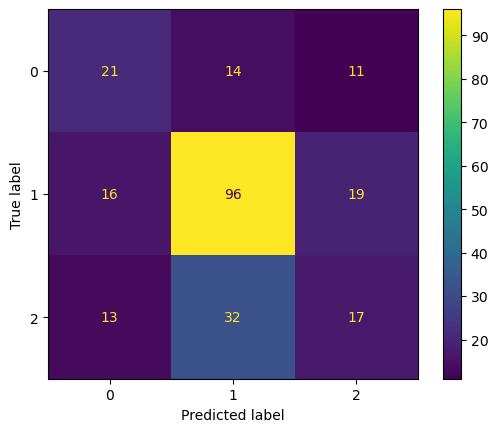

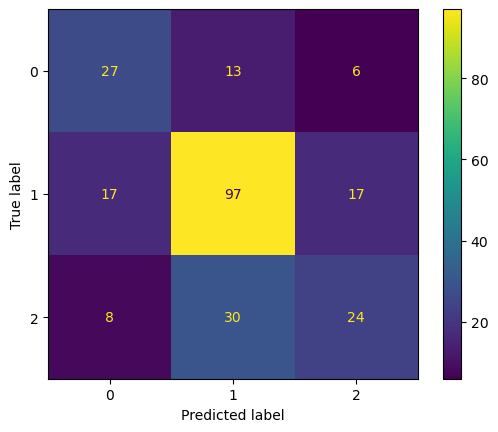

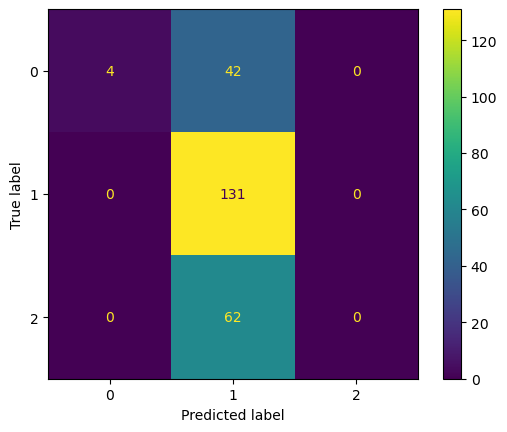

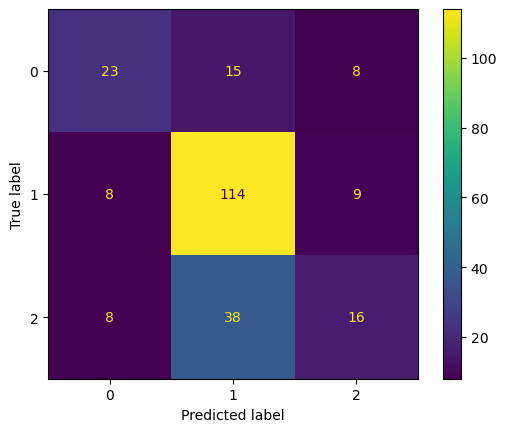

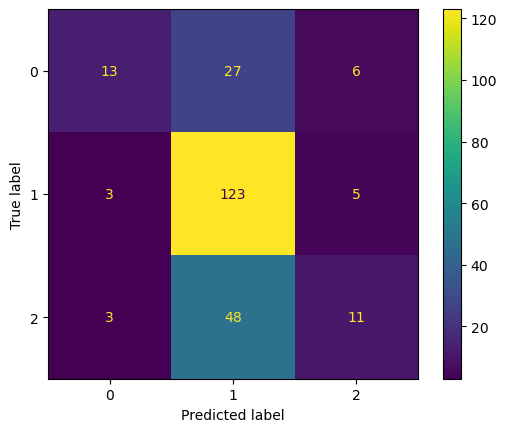

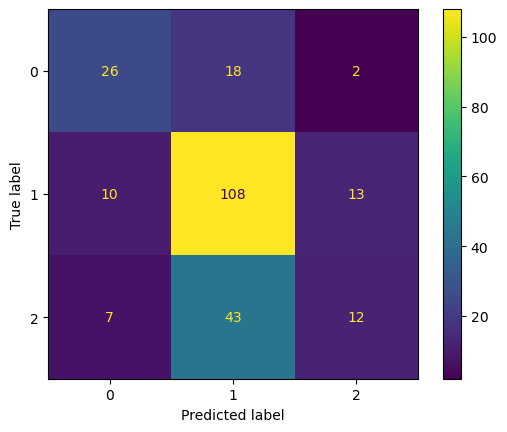

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

for clf, name in zip(trained, names):
    y_pred = clf.predict(X_test)
    print("\n" + name)
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

## 0 = early
## 1 = late
## 2 = middle

In [ ]:
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit
# import matplotlib.pyplot as plt

# train_sizes, train_scores, test_scores = learning_curve(
#     clf, X, y, cv=5, scoring="accuracy"
# )

# plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train")
# plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test")
# plt.legend()
# plt.xlabel("Training Set Size")
# plt.title("Learning Curve")